In [1]:
from PIL import Image
import numpy as np
from scipy.fftpack import fft,ifft
import matplotlib.pyplot as plt
from matplotlib.pylab import mpl
from numpy import sin,cos,pi
import math
import h5py
from scipy.linalg import hadamard,toeplitz
import torch
from tqdm import tqdm
import cv2
import scipy.io as scio

In [6]:
def matmul_complex(t1,t2):
    return torch.view_as_complex(torch.stack((t1.real @ t2.real - t1.imag @ t2.imag, t1.real @ t2.imag + t1.imag @ t2.real),dim=2))

In [7]:
def cs_omp(y,Phi,N,K,Psi=None, device="cpu", dtype=torch.float32):    
    residual = y.to(device)  #初始化残差
    Phi = Phi.to(device)
    index = torch.zeros(N,dtype=int,device=device)
    for i in range(N): #第i列被选中就是1，未选中就是-1
        index[i]= -1
    result= torch.zeros((N,1),dtype=dtype,device=device)
    for j in tqdm(range(K)):  #迭代次数
        
        product=torch.abs(Phi.T @ residual)
        pos=torch.argmax(product)  #最大投影系数对应的位置        
        index[pos]=1 #对应的位置取1
        inv_d=Phi[:,index>=0]
        
        inv=inv_d.T @ inv_d
        my=torch.linalg.inv(inv) @ inv_d.T
        
        a=my @ y # 最小二乘,看参考文献  
        residual=y-inv_d @ a
    
    result[index>=0]=a.reshape((-1,1))
    Candidate = torch.where(index>=0) #返回所有选中的列
    if Psi is not None:
        result = torch.real(Psi.to(device) @ result)
        
    return result, Candidate

(800,)


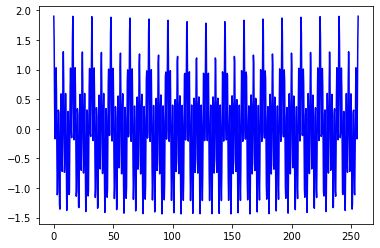

In [8]:
#生成原始信号
f1=50    
f2=100  
f3=200  
f4=400   
fs=N=800  
x=np.linspace(0,256,fs)
y=0.3*cos(2*pi*f1*x)+0.6*cos(2*pi*f2*x)+0.1*cos(2*pi*f3*x)+0.9*cos(2*pi*f4*x)
print(x.shape)
plt.plot(x,y,"b")

In [9]:
fft_matrix = lambda N,device,dtype: torch.fft.fft2(torch.eye(N,N,device=device,dtype=dtype))/np.sqrt(N)

def dct_matrix(N,device,dtype=torch.float32):
    psi=torch.zeros((N,N),device=device,dtype=dtype)
    for q in range(N):
        t=np.zeros((N,1))
        t[q,0]=1
        psi[:,q]= torch.tensor(cv2.idct(t).reshape((-1,)),device=device,dtype=dtype)
    return psi

In [11]:
np.random.seed(1234) 
torch.manual_seed(1234)

def delta(m,n,u,v,fi=0):
    res=np.zeros((m,n))
    res[u,v]=np.exp(complex('j')*fi)
    return res 


"""
随机 svd 组合而成的观测矩阵
B,C 共用同一个观测矩阵 
"""
def get_random_svd_compose_measure_matrix(M: int, N:int, device,dtype=torch.float32):
    some=False
    Vt = torch.rand(N, N,device=device,dtype=dtype)
    Vt, _ = torch.linalg.qr(Vt, 'reduced' if some else 'complete')   # N*N  正交矩阵
    U = torch.rand(M, M,device=device,dtype=dtype)
    U, _ = torch.linalg.qr(U, 'reduced' if some else 'complete')     # M*M  正交矩阵
    S = torch.hstack(
      (
        torch.eye(M,dtype=dtype),   # M*M 对角矩阵
        torch.zeros(M, N-M,dtype=dtype)  # M*(N-M) 全0 
      )
    ).to(device)  # M*N
    H = torch.matmul(U, torch.matmul(S, Vt))  # H = USV
    return H
            
"""
随机高斯观测矩阵
"""
def get_gussian_measure_matrix(M: int, N:int, device, sigma=0.5,dtype=torch.float32):
    return sigma * torch.randn(M,N,device=device,dtype=dtype)


"""
随机伯努利观测矩阵
"""
def get_bernoulli_measure_matrix(M: int, N:int,device,dtype=torch.float32):
    H = torch.randint(0,2, (M,N),device=device,dtype=dtype)
    H[H==0] = -1
    return H


"""
随机稀疏矩阵
"""
def get_sparse_random_measure_matrix(M: int, N:int,device, d=0.5,dtype=torch.float32):
    H = torch.zeros((M, N),device=device,dtype=dtype)
    d = int(M*d) if d<1 else d
    for i in range(N):
        H[np.random.choice(np.arange(M), d),i]=1
    return H


"""
托普利兹矩阵和循环矩阵
"""
def get_toeplitz_loop_measure_matrix(M: int, N:int,device,dtype=torch.float32):
    u = np.random.randint(0,2, (N,))
    u[u==0] = -1
    H=torch.empty((M,N),device=device,dtype=dtype)
    for i in range(M):
        u=np.roll(u,1)
        H[i,:]=torch.tensor(u,device=device,dtype=dtype)
    return H
        


"""
部分哈达玛观测矩阵 N 无法大太 N 必须为 2 次幂
"""
def get_part_hada_measure_matrix(M: int, N:int,device,dtype=torch.float32):
    hada = hadamard(N)
    random_rows = np.random.choice(np.arange(N), M)
    return torch.tensor(hada[random_rows, :],device=device,dtype=dtype)
    

"""
上一个方法的替代 部分哈达玛观测矩阵 N 为平方数
"""
def get_hada_measure_matrix(M: int, N:int,device,dtype=torch.float32):
    size=int(np.sqrt(N))
    measure_matrix = torch.empty((M,N),device=device,dtype=dtype)
    k=0
    Hada = hadamard(size)
    x,y = np.arange(size),np.arange(size)
    np.random.shuffle(x)
    np.random.shuffle(y)
    for i in x:
        for j in y:
            Delta=delta(size,size,i,j)
            W=np.dot(np.dot(Hada,Delta),Hada)
            measure_matrix[k,:] = W.reshape((N,))
            k+=1
            if k>=M:
                return measure_matrix
            
    return measure_matrix

"""
正弦余弦观测 N 为平方数
"""
def get_fft_measure_matrix(M: int, N:int,device,fi=2*np.pi/3,dtype=torch.float32):
    size=int(np.sqrt(N))
    measure_matrix = torch.empty((M,N),device=device,dtype=dtype)
    k=0
    x,y = np.arange(size),np.arange(size)
    np.random.shuffle(x)
    np.random.shuffle(y)
    for i in x:
        for j in y:
            Delta=delta(size,size,i,j,fi)
            W=np.fft.ifft2(Delta).real
            measure_matrix[k,:] = torch.tensor(W.reshape((N,)),device=device,dtype=dtype)
            k+=1
            if k>=M:
                return measure_matrix
            
    return measure_matrix

In [12]:
device="cuda"
dtype=torch.float32
M=65
Gaussian = get_gussian_measure_matrix(M,N,device=device,dtype=dtype)
# 观测值
sampled = Gaussian @ torch.tensor(y,device=device,dtype=dtype) 

# 计算感知矩阵
Psi = dct_matrix(N,device,dtype=dtype)  # 傅里叶稀疏基
A = Gaussian @ Psi    # 传感矩阵 A =ΦΨ
print(A.shape)

torch.Size([65, 800])


In [13]:
# 重建
K=8
show_start=100
show_end=200
result,_=cs_omp(sampled,A,N,K,Psi,device=device,dtype=dtype)

100%|██████████| 8/8 [00:00<00:00, 1019.21it/s]


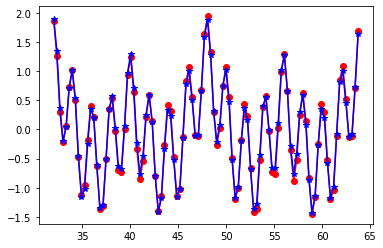

In [14]:
plt.plot(x[show_start:show_end],(result.cpu())[show_start:show_end],"r",marker='o')
plt.plot(x[show_start:show_end],y[show_start:show_end],"b",marker='*')

In [15]:
def cs_image(image, measure_matrix, spare_matrix, _K = None, measure_rate=0.3, device="cpu",dtype=torch.float32, y=None):
    """
    im: C H W 
    """
    C,H,W = image.shape
    N=H*W
    M = int(measure_rate*N)

    Phi = measure_matrix(M,N,device=device,dtype=dtype)
    mat_dct_1d = spare_matrix(N,device=device,dtype=dtype)
    
    K = int(2.99 * M / 3) if _K is None else _K    
    Theta_1d=Phi @ mat_dct_1d   # 感知矩阵
    
    img_rec=torch.zeros((C,H,W),device=device,dtype=dtype)   # 初始化稀疏系数矩阵
    for c in range(C):
        im = image[c,:,:]
        img_cs_1d = Phi @ im.reshape((-1,)) if y is None else y[c,0,:].squeeze(0)
        print(img_cs_1d.shape)
        column_rec,_ = cs_omp(img_cs_1d, Theta_1d, N, K, mat_dct_1d,device=device,dtype=dtype) 
        img_rec[c,:,:] = column_rec.reshape((H,W)) 

    return img_rec

In [33]:
def cs_image_no_sparse(image, measure_matrix, _K = None, measure_rate=0.3, device="cpu",dtype=torch.float32, y=None):
    """
    im: C H W 
    """
    C,H,W = image.shape
    N=H*W
    M = int(measure_rate*N)

    Phi = measure_matrix(M,N,device=device,dtype=dtype)
    
    K = int(2.99 * M / 3) if _K is None else _K    
    Theta_1d=Phi   # 感知矩阵
    
    img_rec=torch.zeros((C,H,W),device=device,dtype=dtype)   # 初始化稀疏系数矩阵
    for c in range(C):
        im = image[c,:,:]
        img_cs_1d = Theta_1d @ im.reshape((-1,)) if y is None else y[c,0,:].squeeze(0)
        print(img_cs_1d.shape)
        column_rec,_ = cs_omp(img_cs_1d, Theta_1d, N, K,device=device,dtype=dtype) 
        img_rec[c,:,:] = column_rec.reshape((H,W)) 

    return img_rec

In [16]:
f = h5py.File("./recvs/A_1_A_2_GI_A_recv.h5")
A_1 = np.array(f["A_1"])
A_2 = np.array(f["A_2"])

In [17]:
dtype=torch.float64

In [18]:
metadata = scio.loadmat("./recvs/PM1/Lena.mat")
x = torch.tensor(np.array(metadata["x"])[0],device=device,dtype=dtype)
y = torch.tensor(np.array(metadata["y"]),device=device,dtype=dtype)
A_recv = torch.tensor(np.array(metadata["A_recv"]),device=device,dtype=dtype)
print(x)
print(y)
print(A_recv)
error=A_recv @ x.reshape((-1,1)) - y.reshape((-1,1))
print(error)
print(abs(error).mean())

tensor([[[0.6353, 0.6275, 0.6353,  ..., 0.4627, 0.6471, 0.6392],
         [0.6314, 0.6275, 0.6235,  ..., 0.4941, 0.5294, 0.3647],
         [0.6118, 0.6078, 0.6157,  ..., 0.4157, 0.2039, 0.1882],
         ...,
         [0.2039, 0.2000, 0.2510,  ..., 0.2275, 0.2157, 0.2471],
         [0.2039, 0.2078, 0.2196,  ..., 0.2275, 0.2667, 0.3451],
         [0.1882, 0.1922, 0.1922,  ..., 0.2706, 0.3529, 0.4039]]],
       device='cuda:0', dtype=torch.float64)
tensor([[[4627.7573, 4044.9463, 3594.7773,  ..., 4343.1470, 4322.7227,
          4163.9482]]], device='cuda:0', dtype=torch.float64)
tensor([[0.2485, 0.1043, 0.3404,  ..., 0.1300, 0.2723, 0.3060],
        [0.2641, 0.1536, 0.3261,  ..., 0.1246, 0.2513, 0.2919],
        [0.2170, 0.1194, 0.2698,  ..., 0.1747, 0.2650, 0.2830],
        ...,
        [0.2702, 0.1252, 0.3456,  ..., 0.0760, 0.2274, 0.2679],
        [0.2807, 0.1454, 0.3502,  ..., 0.0519, 0.1822, 0.2172],
        [0.2310, 0.1058, 0.3041,  ..., 0.0989, 0.2253, 0.2583]],
       device='cud

In [19]:
metadata = scio.loadmat("./recvs/PM2/Lena.mat")
x = torch.tensor(np.array(metadata["x"])[0],device=device,dtype=dtype)
y = torch.tensor(np.array(metadata["y"]),device=device,dtype=dtype)
A_recv = torch.tensor(np.array(metadata["A_recv"]),device=device,dtype=dtype)
print(x)
print(y)
print(A_recv)
error=A_recv @ x.reshape((-1,1)) - y.reshape((-1,1))
print(error)
print(abs(error).mean())

tensor([[[0.6353, 0.6275, 0.6353,  ..., 0.4627, 0.6471, 0.6392],
         [0.6314, 0.6275, 0.6235,  ..., 0.4941, 0.5294, 0.3647],
         [0.6118, 0.6078, 0.6157,  ..., 0.4157, 0.2039, 0.1882],
         ...,
         [0.2039, 0.2000, 0.2510,  ..., 0.2275, 0.2157, 0.2471],
         [0.2039, 0.2078, 0.2196,  ..., 0.2275, 0.2667, 0.3451],
         [0.1882, 0.1922, 0.1922,  ..., 0.2706, 0.3529, 0.4039]]],
       device='cuda:0', dtype=torch.float64)
tensor([[[4627.7573, 4044.9463, 3594.7773,  ..., 4343.1470, 4322.7227,
          4163.9482]]], device='cuda:0', dtype=torch.float64)
tensor([[0.2148, 0.1486, 0.2203,  ..., 1.0973, 1.0391, 0.8540],
        [0.1907, 0.1341, 0.1960,  ..., 0.9429, 0.8923, 0.7307],
        [0.1755, 0.1259, 0.1797,  ..., 0.8073, 0.7664, 0.6327],
        ...,
        [0.1789, 0.1166, 0.1829,  ..., 1.0121, 0.9604, 0.7920],
        [0.1961, 0.1304, 0.1954,  ..., 1.0158, 0.9617, 0.7878],
        [0.1945, 0.1358, 0.1973,  ..., 0.9654, 0.9171, 0.7614]],
       device='cud

In [21]:
# N = 128*128
# dct_matrix = dct_matrix(N,device=device,dtype=dtype)
# inv_dct_matrix = torch.inverse(dct_matrix)

In [32]:
# scio.savemat('./recvs/dct_matrix.mat', {'dct_matrix': dct_matrix.cpu().numpy(), "inv_dct_matrix":inv_dct_matrix.cpu().numpy()})

In [ ]:
names=[
    "GI",
    "Baboon",
    "Barbara",
    "Cameraman",
    "Goldhill",
    "Lena",
    "Peppers"
]
PMS = [
    "PM1",
    # "PM2",
    # "PM3"
]
PM_res=[]
for pm in PMS:
    res=[]
    for name in names:
        metadata = scio.loadmat("./recvs/{}/{}.mat".format(pm,name))
        x = torch.tensor(np.array(metadata["x"])[0],device=device,dtype=dtype)
        y = torch.tensor(np.array(metadata["y"]),device=device,dtype=dtype)
        print(y.shape)
        A_recv = np.array(metadata["A_recv"])
        get_A = lambda M,N,device=device,dtype=dtype: torch.tensor(A_recv,device=device,dtype=dtype)
        img_rec = cs_image_no_sparse(x, get_A, measure_rate=0.1526, device=device,dtype=dtype, y=y).cpu().numpy().squeeze(0)
        res.append(img_rec)
        print("====================")
    PM_res.append(res)

torch.Size([1, 1, 2500])
torch.Size([2500])


100%|██████████| 2491/2491 [00:23<00:00, 105.93it/s]


torch.Size([1, 1, 2500])
torch.Size([2500])


100%|██████████| 2491/2491 [01:30<00:00, 27.50it/s]


torch.Size([1, 1, 2500])
torch.Size([2500])


100%|██████████| 2491/2491 [00:33<00:00, 74.05it/s]


torch.Size([1, 1, 2500])
torch.Size([2500])


 58%|█████▊    | 1449/2491 [00:20<00:19, 53.75it/s]

In [18]:
idxs=[0,1,6,4,2,3,5]
PM_res_ordered=[]
for res in PM_res:
    PM_res_ordered.append([res[i] for i in idxs])

In [22]:
# f = h5py.File("./recvs/res/float64_OMP_res.h5","w")
# f.create_dataset("value", data = np.array(PM_res_ordered))
# f.close()

In [2]:
f = h5py.File("./recvs/res/float64_OMP_res.h5")
a = np.array(f["value"])
f.close()
a.shape

(3, 7, 128, 128)

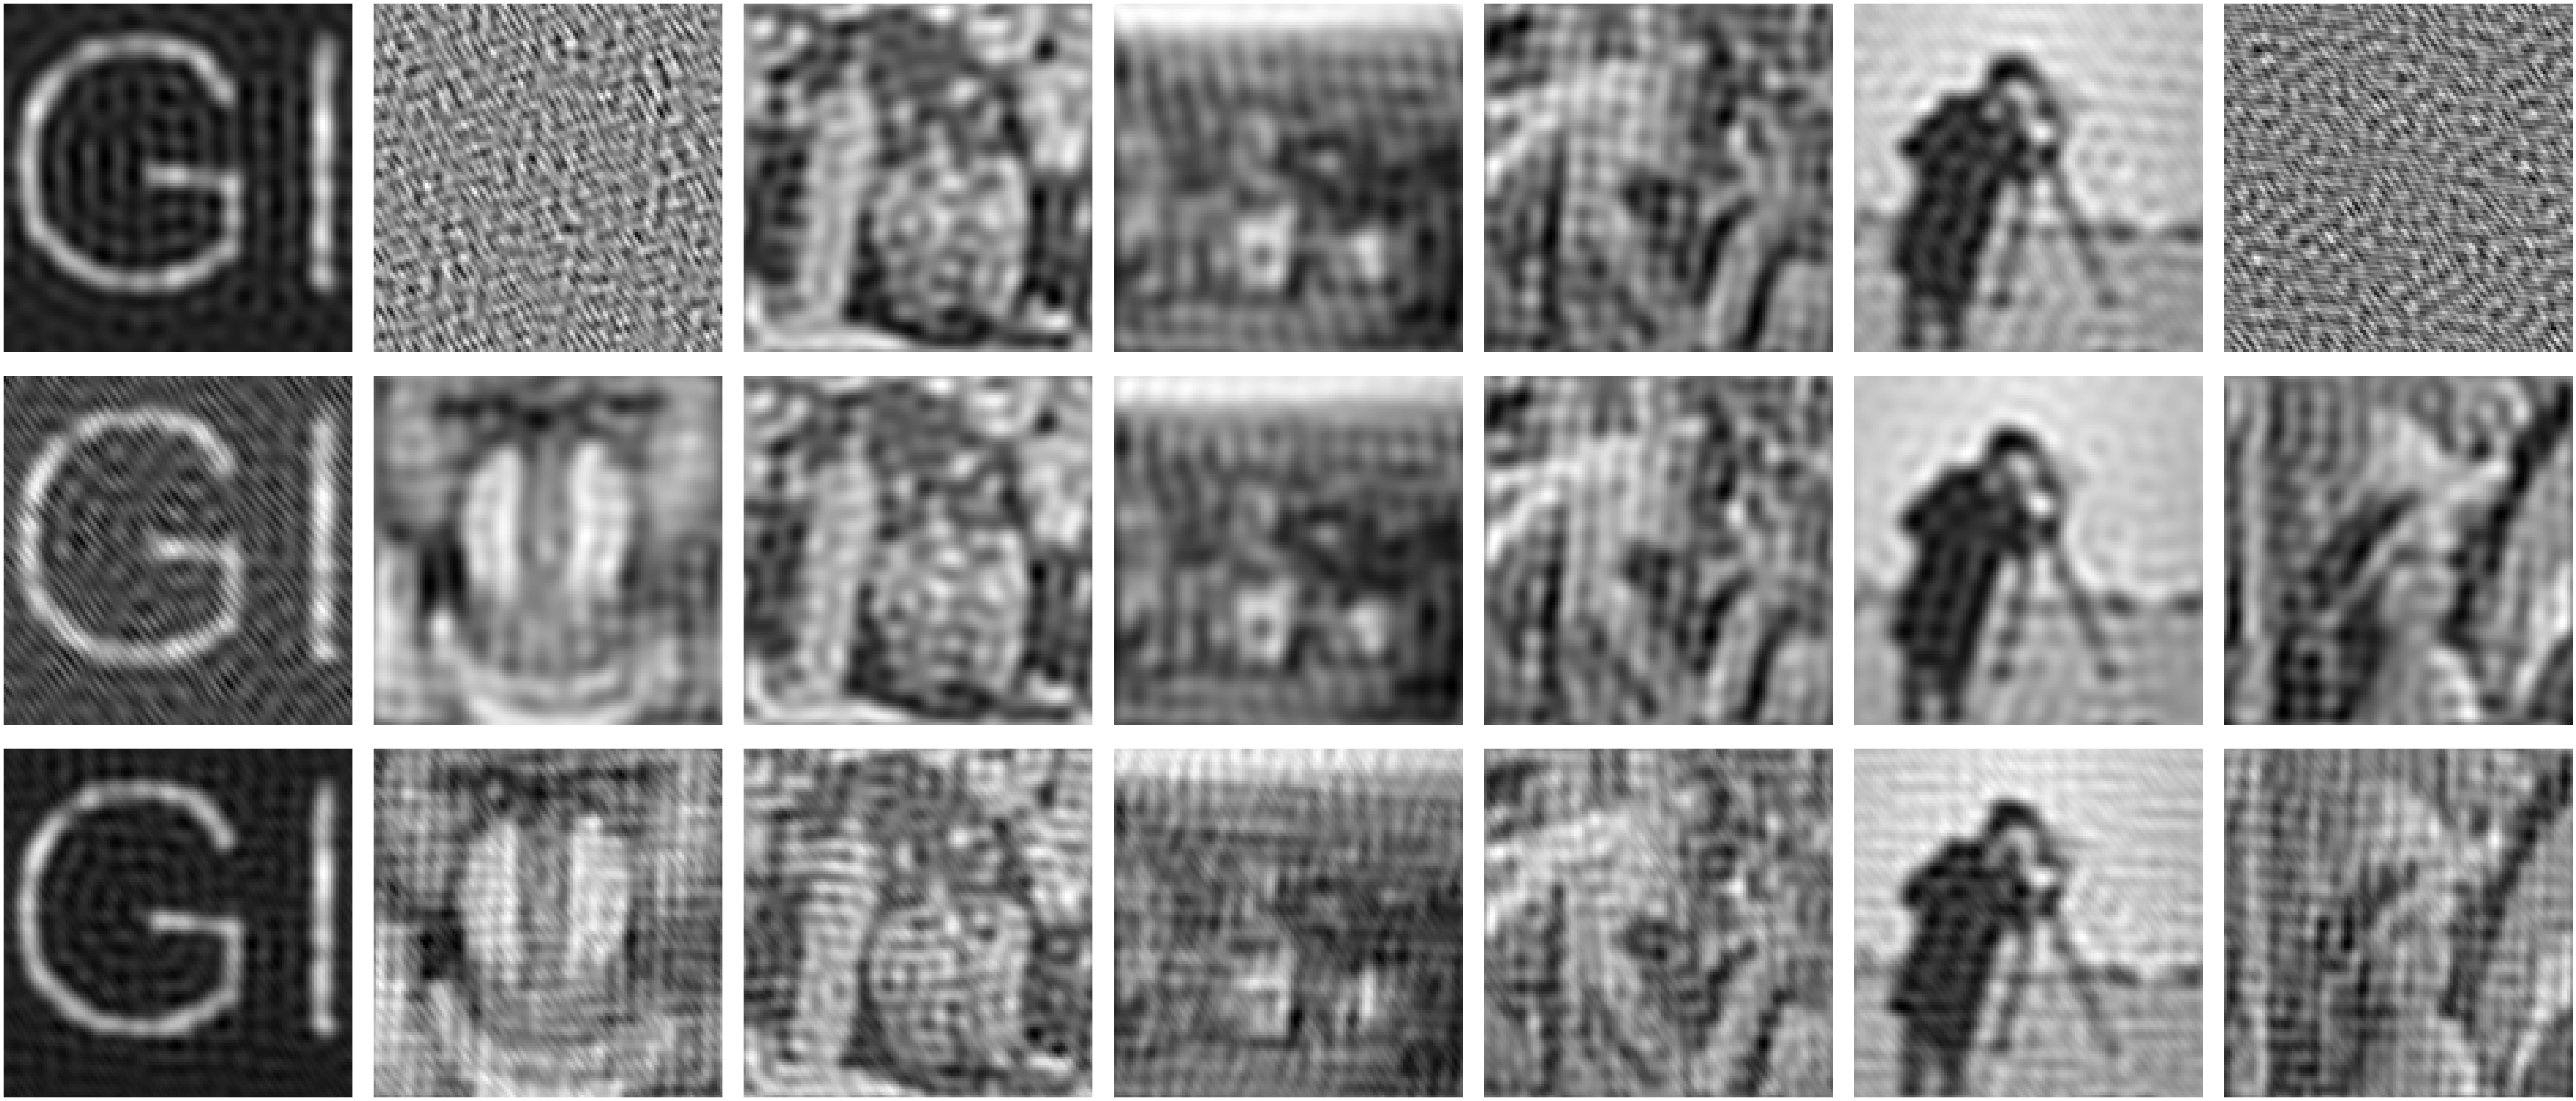

In [5]:
plt.figure(figsize=(7*10,3*10))
for i in range(7):
    plt.subplot(3,7,i+1)
    plt.imshow(a[0][i],cmap="gray")
    plt.axis("off")

    plt.subplot(3,7,i+1+7)
    plt.imshow(a[1][i],cmap="gray")
    plt.axis("off")

    plt.subplot(3,7,i+1+7*2)
    plt.imshow(a[2][i],cmap="gray")
    plt.axis("off")
    
plt.tight_layout(pad=2, h_pad=5)
# plt.savefig("./recvs/res/A_recv_OMP_float64_res.jpg")